In [1440]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import random

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

students = pd.read_csv('stud_math.csv')

## First data inspection

In [1441]:
display(students.sample(10))
students.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
340,GP,F,19,U,GT3,T,2.0,1.0,services,services,home,other,1.0,3.0,1.0,no,no,yes,yes,NaN,-9.0,yes,NaN,yes,4.0,3.0,4.0,3.0,4.0,55.0
148,GP,M,16,U,GT3,T,4.0,4.0,teacher,teacher,course,mother,1.0,1.0,0.0,no,yes,NaN,no,yes,-3.0,no,yes,yes,3.0,3.0,2.0,5.0,0.0,0.0
280,GP,M,17,U,NaN,A,4.0,NaN,services,other,home,mother,2.0,1.0,NaN,no,no,yes,yes,yes,-3.0,yes,yes,NaN,4.0,NaN,4.0,5.0,30.0,40.0
361,MS,M,18,R,LE3,T,1.0,1.0,at_home,other,other,mother,2.0,2.0,1.0,no,no,no,yes,no,-6.0,no,no,no,4.0,4.0,3.0,5.0,2.0,60.0
150,GP,M,18,U,LE3,T,1.0,1.0,other,other,course,mother,1.0,1.0,3.0,no,no,no,no,yes,-3.0,no,yes,yes,2.0,3.0,5.0,4.0,NaN,0.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
118,GP,M,17,R,GT3,T,1.0,3.0,other,NaN,course,father,3.0,2.0,1.0,no,yes,no,yes,yes,-6.0,yes,NaN,no,NaN,2.0,4.0,5.0,20.0,40.0
84,GP,F,15,U,GT3,T,1.0,1.0,other,other,home,father,1.0,2.0,0.0,no,yes,no,yes,no,-6.0,NaN,yes,no,4.0,3.0,2.0,4.0,2.0,50.0
151,GP,M,16,U,LE3,T,2.0,1.0,at_home,NaN,course,mother,1.0,1.0,1.0,NaN,no,no,yes,yes,-3.0,yes,no,yes,4.0,4.0,4.0,5.0,6.0,70.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

### Pre-processing functions

In [1442]:
def fill_empty_random(df, col):
    # Fills empty positions at column col with a randomly selected value which belongs to the same column and at a
    # same frequency as this value appears in a column 
    values = random.choices(df[col].value_counts().index, df[col].value_counts().values, 
                                                          k= np.size(np.where(pd.isnull(df[col]))))
    
    empty = np.where(pd.isnull(df[col]))
 
    pares = {}
    for a,b in zip(empty[0], values):
        pares[a] = b
      
    df[col].fillna(value=pares, inplace=True)
    return df

def replace_fail_with_nan(df, col, allowed):
    # Set elements of the column col which are not in allowed list to NaN 
    df[col] = df[col].apply(lambda x: x if x in allowed else np.nan)
    return df


### Pre-process columns with nominative and ordinal variables with known specification first


In [1443]:
# Generate report for each nominative and ordinal variable with known state and apply pro-processing functions
# in case of missing or illegal data present. For such variables this operation can be automated.

nom_categories = { "sex" : ["F", "M"],
                   "address": ["U", "R"],
                   "famsize" : [ "LE3", "GT3"],
                   "Pstatus" : ["T", "A"],
                   "Medu" : [0, 1, 2, 3, 4],
                   "Fedu" : [0, 1, 2, 3, 4],
                   "Mjob": ['teacher', 'health', 'services', 'at_home', 'other'],
                   "Fjob" : ['teacher', 'health', 'services', 'at_home', 'other'],
                   "reason" : ['home', 'reputation', 'course', 'other'],
                   "guardian" : ["mother", "father", "other"],
                   "traveltime" : [1, 2, 3, 4],
                   "studytime" : [1, 2, 3, 4],
                   "failures" : [0, 1, 2, 3],
                   "schoolsup" : ["yes", "no"],
                   "famsup" : ["yes", "no"],
                   "paid" : ["yes", "no"],
                   "activities" : [ "yes", "no"],
                   "nursery" : [ "yes", "no" ],
                   "higher" : ["yes", "no"],
                   "internet" : ["yes", "no"],
                   "romantic" : ["yes", "no"],
                   "famrel" : [1, 2, 3, 4, 5],
                   "freetime" : [1, 2, 3, 4, 5],
                   "goout" : [1, 2, 3, 4, 5],
                   "health" : [1, 2, 3, 4, 5],
                  }

for col in nom_categories:
    printmd(f"### {col}")
    display(students[col].value_counts(dropna=False))
    replace_empty = False
    
    if np.nan in students[col].value_counts(dropna=False).index:
        printmd(f"#### Missing values: {students[col].value_counts(dropna=False).loc[np.nan]}")
        replace_empty = True
    else:
        printmd(f"#### No Missing values")
        
    unexpected_val = set(students[col].dropna().unique()) - set(nom_categories[col])
    
    if unexpected_val:
        printmd(f"#### Unexpected values found: {unexpected_val}")
        #At first replace with NaN to prepare for the next step
        students = replace_fail_with_nan(students, col, [0,1,2,3,4])
        replace_empty = True
    else:
        printmd(f"#### No Unexpected values discovered")
        
    if replace_empty:
        #Filling missing data by randomly selected valid values with same frequency as in remaining part of the sample:
        students = fill_empty_random(students, col)
   
    printmd("**--------------------------------------------------------**")

### sex

F    208
M    187
Name: sex, dtype: int64

#### No Missing values

#### No Unexpected values discovered

**--------------------------------------------------------**

### address

U      295
R       83
NaN     17
Name: address, dtype: int64

#### Missing values: 17

#### No Unexpected values discovered

**--------------------------------------------------------**

### famsize

GT3    261
LE3    107
NaN     27
Name: famsize, dtype: int64

#### Missing values: 27

#### No Unexpected values discovered

**--------------------------------------------------------**

### Pstatus

T      314
NaN     45
A       36
Name: Pstatus, dtype: int64

#### Missing values: 45

#### No Unexpected values discovered

**--------------------------------------------------------**

### Medu

4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
NaN      3
Name: Medu, dtype: int64

#### Missing values: 3

#### No Unexpected values discovered

**--------------------------------------------------------**

### Fedu

2.0     106
3.0      96
4.0      88
1.0      78
NaN      24
0.0       2
40.0      1
Name: Fedu, dtype: int64

#### Missing values: 24

#### Unexpected values found: {40.0}

**--------------------------------------------------------**

### Mjob

other       133
services     98
at_home      58
teacher      55
health       32
NaN          19
Name: Mjob, dtype: int64

#### Missing values: 19

#### No Unexpected values discovered

**--------------------------------------------------------**

### Fjob

other       197
services    102
NaN          36
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

#### Missing values: 36

#### No Unexpected values discovered

**--------------------------------------------------------**

### reason

course        137
home          104
reputation    103
other          34
NaN            17
Name: reason, dtype: int64

#### Missing values: 17

#### No Unexpected values discovered

**--------------------------------------------------------**

### guardian

mother    250
father     86
NaN        31
other      28
Name: guardian, dtype: int64

#### Missing values: 31

#### No Unexpected values discovered

**--------------------------------------------------------**

### traveltime

1.0    242
2.0     96
NaN     28
3.0     22
4.0      7
Name: traveltime, dtype: int64

#### Missing values: 28

#### No Unexpected values discovered

**--------------------------------------------------------**

### studytime

2.0    194
1.0    103
3.0     64
4.0     27
NaN      7
Name: studytime, dtype: int64

#### Missing values: 7

#### No Unexpected values discovered

**--------------------------------------------------------**

### failures

0.0    293
1.0     49
NaN     22
2.0     16
3.0     15
Name: failures, dtype: int64

#### Missing values: 22

#### No Unexpected values discovered

**--------------------------------------------------------**

### schoolsup

no     335
yes     51
NaN      9
Name: schoolsup, dtype: int64

#### Missing values: 9

#### No Unexpected values discovered

**--------------------------------------------------------**

### famsup

yes    219
no     137
NaN     39
Name: famsup, dtype: int64

#### Missing values: 39

#### No Unexpected values discovered

**--------------------------------------------------------**

### paid

no     200
yes    155
NaN     40
Name: paid, dtype: int64

#### Missing values: 40

#### No Unexpected values discovered

**--------------------------------------------------------**

### activities

yes    195
no     186
NaN     14
Name: activities, dtype: int64

#### Missing values: 14

#### No Unexpected values discovered

**--------------------------------------------------------**

### nursery

yes    300
no      79
NaN     16
Name: nursery, dtype: int64

#### Missing values: 16

#### No Unexpected values discovered

**--------------------------------------------------------**

### higher

yes    356
NaN     20
no      19
Name: higher, dtype: int64

#### Missing values: 20

#### No Unexpected values discovered

**--------------------------------------------------------**

### internet

yes    305
no      56
NaN     34
Name: internet, dtype: int64

#### Missing values: 34

#### No Unexpected values discovered

**--------------------------------------------------------**

### romantic

no     240
yes    124
NaN     31
Name: romantic, dtype: int64

#### Missing values: 31

#### No Unexpected values discovered

**--------------------------------------------------------**

### famrel

 4.0    182
 5.0     99
 3.0     62
 NaN     27
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

#### Missing values: 27

#### Unexpected values found: {-1.0}

**--------------------------------------------------------**

### freetime

3.0    153
4.0    112
2.0     63
5.0     38
1.0     18
NaN     11
Name: freetime, dtype: int64

#### Missing values: 11

#### No Unexpected values discovered

**--------------------------------------------------------**

### goout

3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
NaN      8
Name: goout, dtype: int64

#### Missing values: 8

#### No Unexpected values discovered

**--------------------------------------------------------**

### health

5.0    138
3.0     89
4.0     63
1.0     47
2.0     43
NaN     15
Name: health, dtype: int64

#### Missing values: 15

#### No Unexpected values discovered

**--------------------------------------------------------**

## Manually check columns with nominative and ordinal variables with unknown specification or missing description

### school

In [1444]:
students.school.value_counts(dropna=False)

GP    349
MS     46
Name: school, dtype: int64

**No unexpected values discovered, no missing values**

### studytime, granular

In [1445]:
students['studytime, granular'].value_counts(dropna=False)

-6.0     194
-3.0     103
-9.0      64
-12.0     27
 NaN       7
Name: studytime, granular, dtype: int64

<AxesSubplot:title={'center':'Father education period'}>

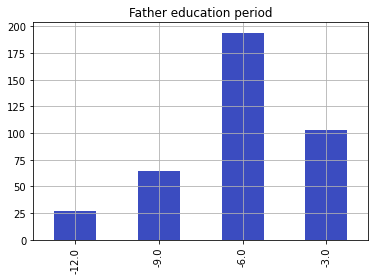

In [1446]:
students['studytime, granular'].value_counts().sort_index().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Father education period')

**Some values are missing, looks like interval variable. Let's fill missing values using same approach as for other nominative variables using fill_empty_random() function**

In [1447]:
studens = fill_empty_random(students, "studytime, granular")

## Check columns with numerical variables

### age

In [1448]:
students.loc[:,["age"]].describe()

,age
count,395.000000
mean,16.696203
std,1.276043
min,15.000000
25%,16.000000
50%,17.000000
75%,18.000000
max,22.000000


<AxesSubplot:>

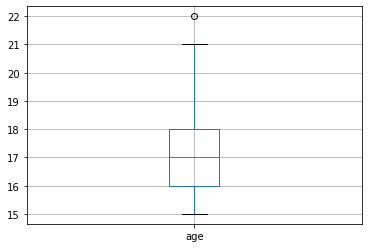

In [1449]:
students.boxplot(column=['age'])

We can see that one outlayer is present with value 22

<AxesSubplot:title={'center':'Students by age'}>

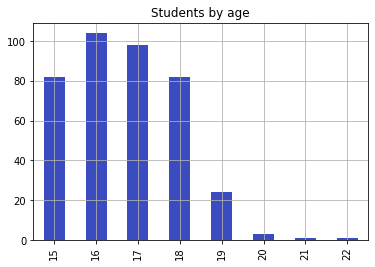

In [1450]:
students['age'].value_counts().sort_index().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Students by age')

Lets replace outlaying value 22, with maximum closes not outlaying value which is 21.

In [1451]:
students["age"].replace(22,21, inplace=True)

In [1452]:
students["age"].value_counts()

16    104
17     98
18     82
15     82
19     24
20      3
21      2
Name: age, dtype: int64

### Absense

In [1453]:
students.loc[:,["absences"]].describe()

,absences
count,383.000000
mean,7.279373
std,23.465197
min,0.000000
25%,0.000000
50%,4.000000
75%,8.000000
max,385.000000


<AxesSubplot:title={'center':'Students by absences'}>

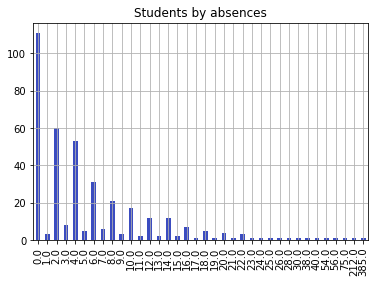

In [1454]:
students.absences.value_counts().sort_index().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Students by absences')

We can see that some values are missing. There are more odd absenses registered per student than even. Let's fill NaN with median value of this sample and look at boxplot.

In [1455]:
students.absences.fillna(students.absences.median())

0        6.0
1        4.0
2       10.0
3        2.0
4        4.0
       ...  
390    212.0
391      3.0
392      3.0
393      0.0
394      5.0
Name: absences, Length: 395, dtype: float64

<AxesSubplot:>

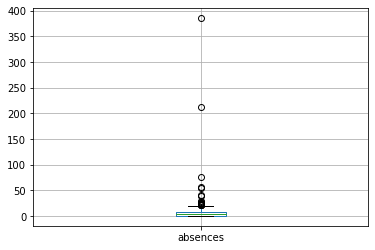

In [1456]:
students.boxplot(column=['absences'])

Boxplot shows that there are many outlayers in this sample. Let's look closer at them:

In [1457]:
Q1 = students.absences.quantile(q=0.25, interpolation='midpoint')
Q2 = students.absences.quantile(q=0.75, interpolation='midpoint')
max_lim =  Q2 + (Q2-Q1) * 1.5 
display(max_lim)

20.0

In [1458]:
students[students["absences"] > 20]["absences"].count()

17

17 outliers detected, let's replace them with 0.75 quartile + 1.5 * IQR

In [1459]:
students["absences"] = students["absences"].apply(lambda x: x if x <= 20 else 20)

### score

In [1460]:
students.loc[:,["score"]].describe()

,score
count,389.000000
mean,52.262211
std,22.919022
min,0.000000
25%,40.000000
50%,55.000000
75%,70.000000
max,100.000000


#### Drop 6 rows where taget value is not specified:


In [1461]:
students.dropna(subset=["score"], inplace=True)
len(students)

389

In [1462]:
students.score = students.score.apply(lambda x: float(x))

<AxesSubplot:title={'center':'Students by score'}>

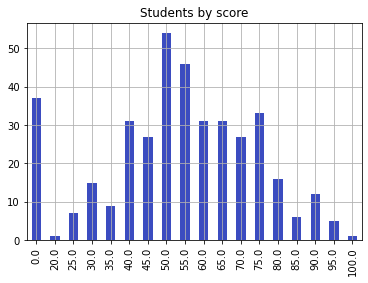

In [1463]:
students.score.value_counts().sort_index().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Students by score')


<AxesSubplot:>

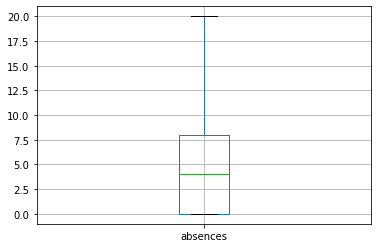

In [1464]:
students.boxplot(column=['absences'])

No outliers! Very good!

## Correlation analisys for quantitative variables

In [1465]:
correlation = students[["age", "absences", "score"]].corr()


<AxesSubplot:>

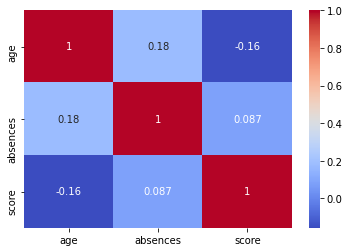

In [1466]:
sns.heatmap(correlation, annot = True, cmap = "coolwarm")

We can see that score and age are not correlated, thus we can use these two samples further.

## Analysis for nominal and ordinal variables

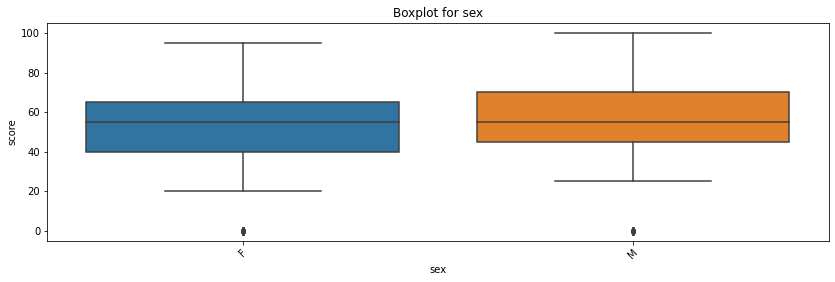

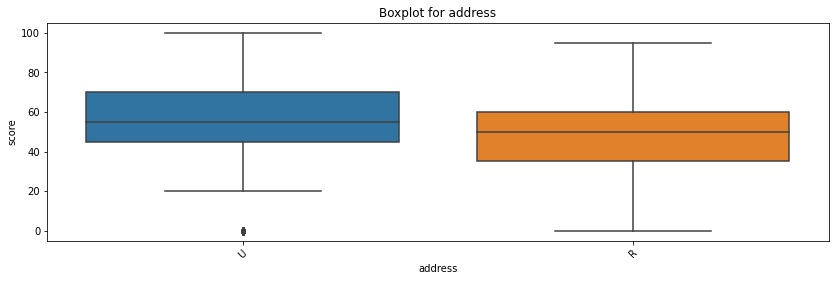

**Statistically significant differences of expected values discovered for column: address**

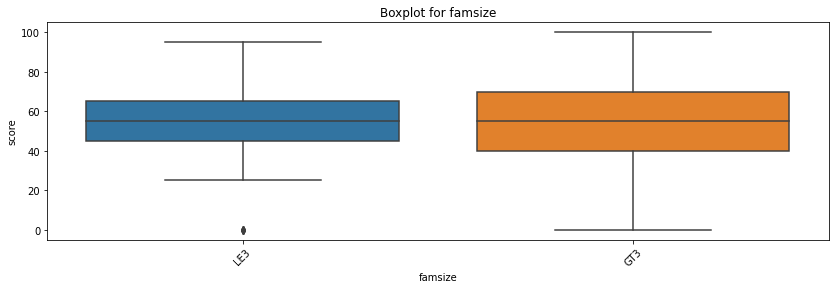

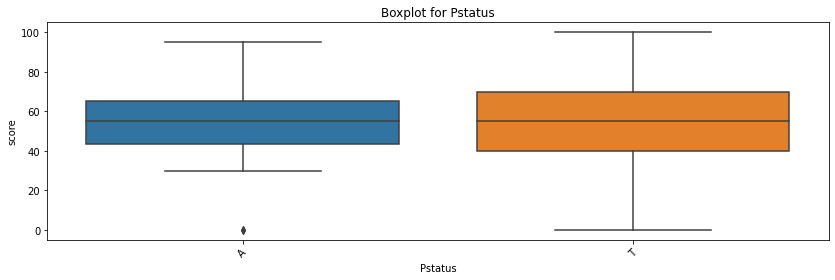

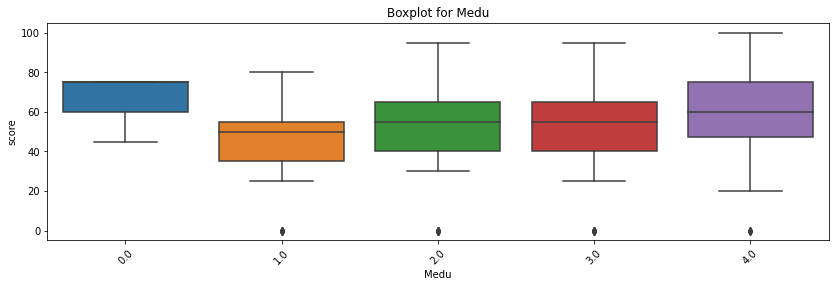

**Statistically significant differences of expected values discovered for column: Medu**

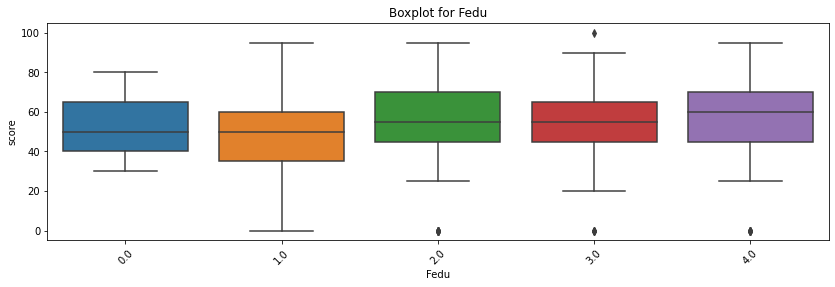

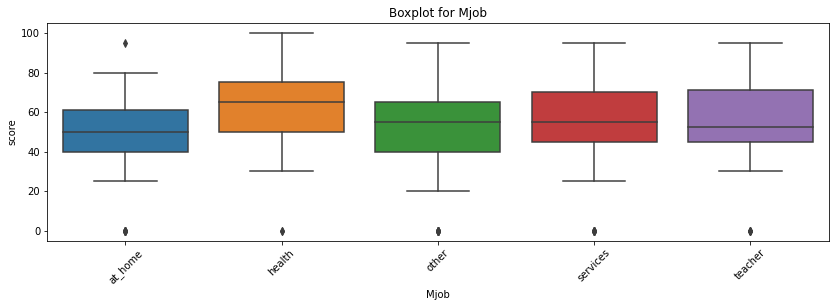

**Statistically significant differences of expected values discovered for column: Mjob**

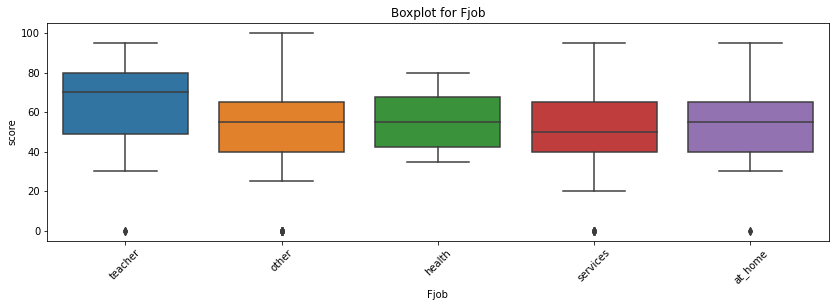

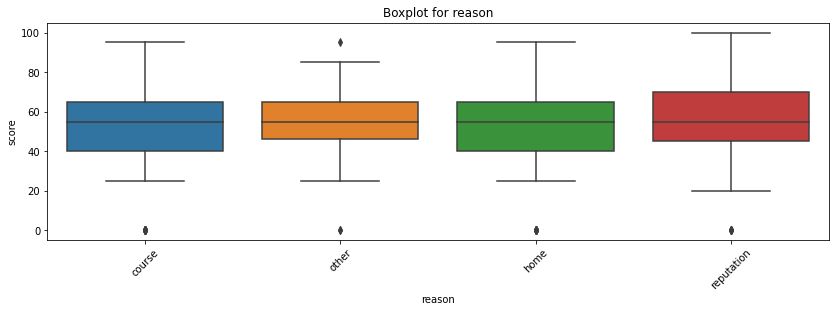

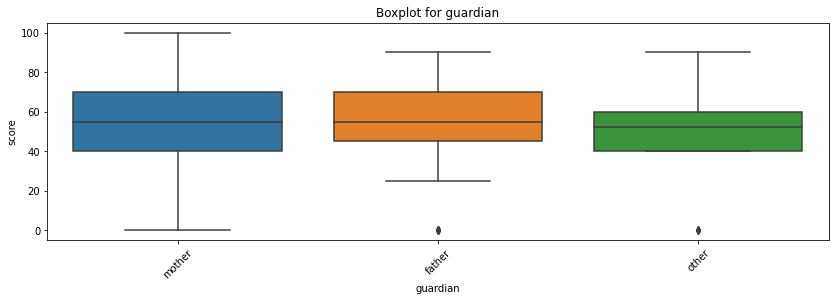

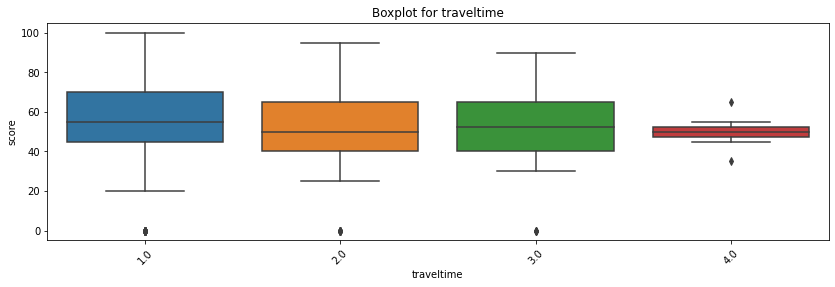

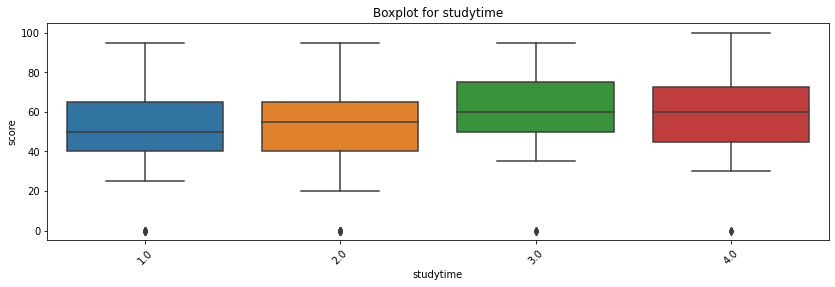

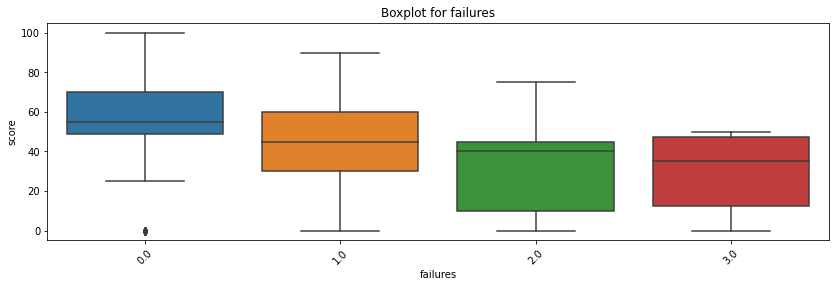

**Statistically significant differences of expected values discovered for column: failures**

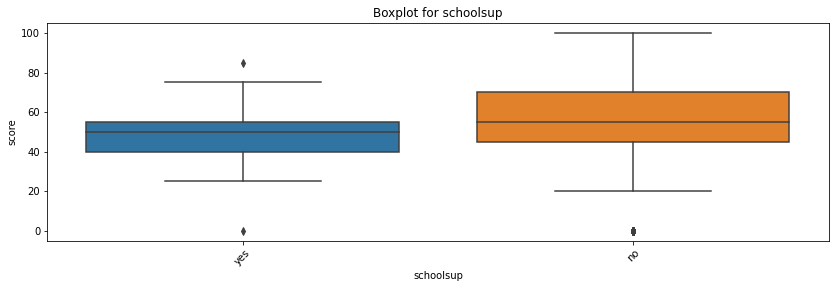

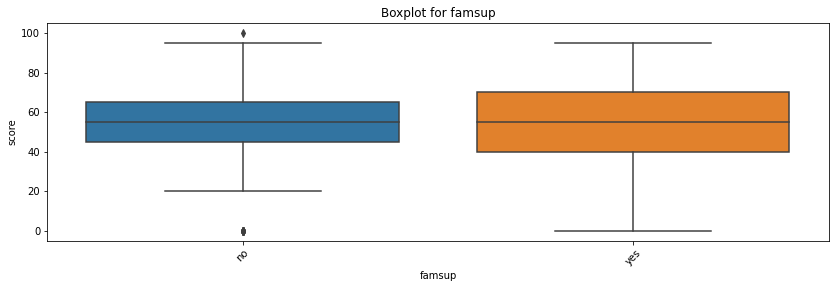

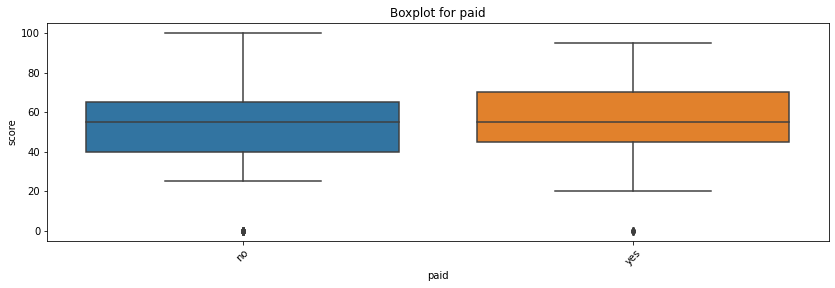

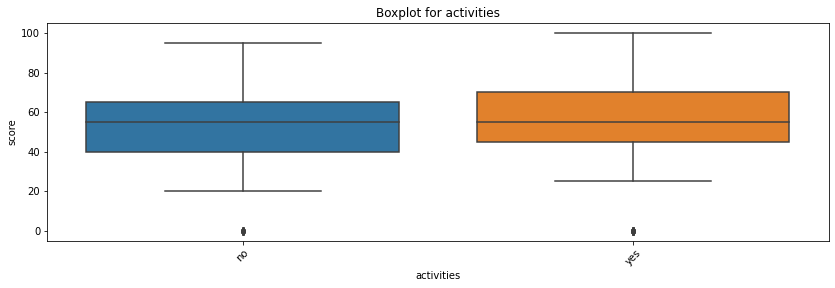

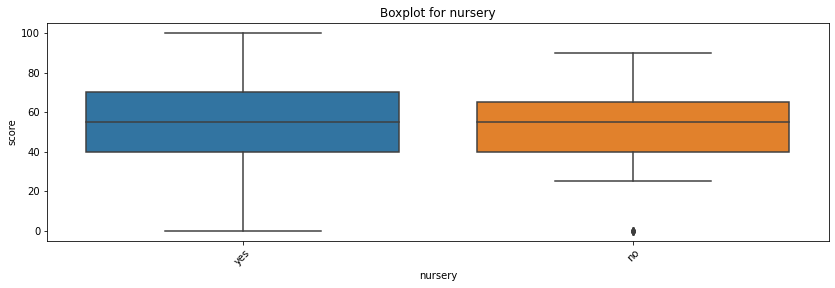

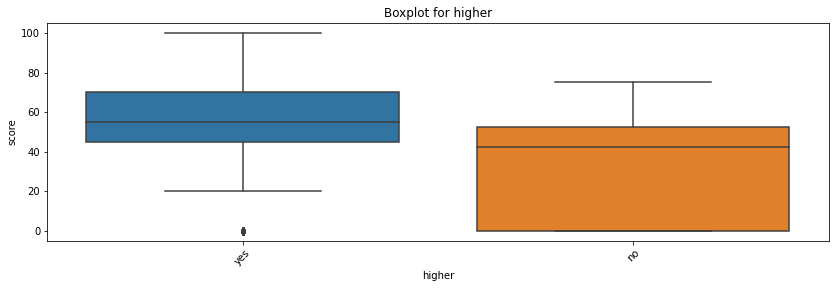

**Statistically significant differences of expected values discovered for column: higher**

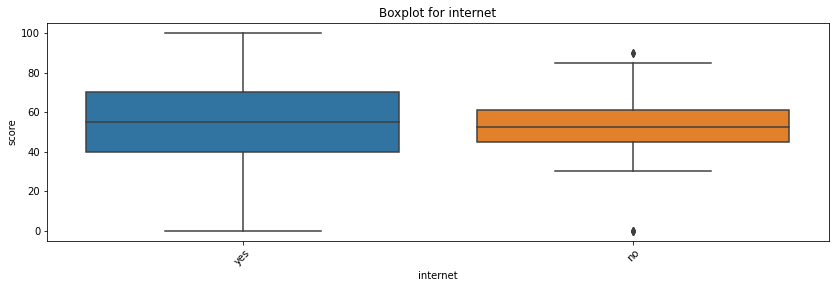

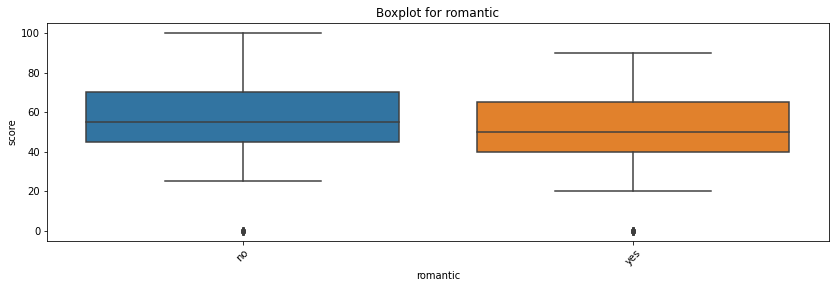

**Statistically significant differences of expected values discovered for column: romantic**

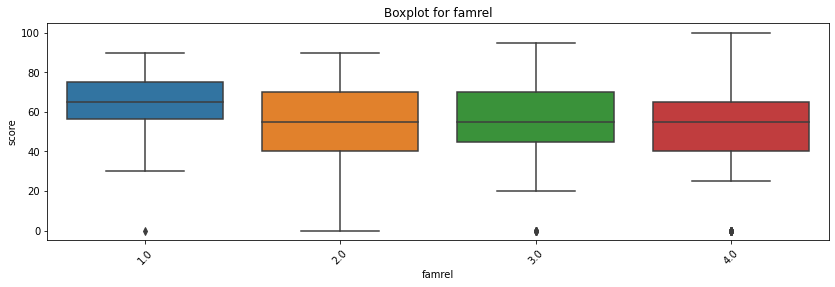

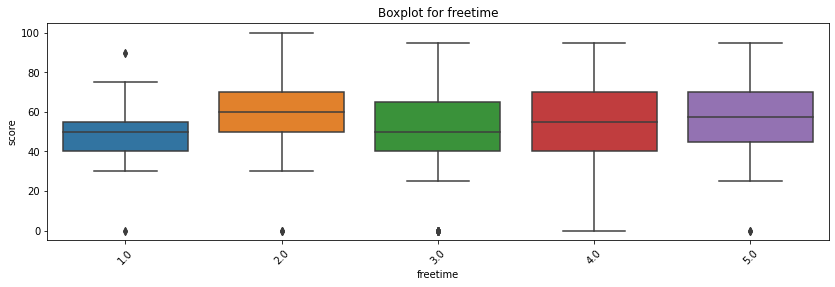

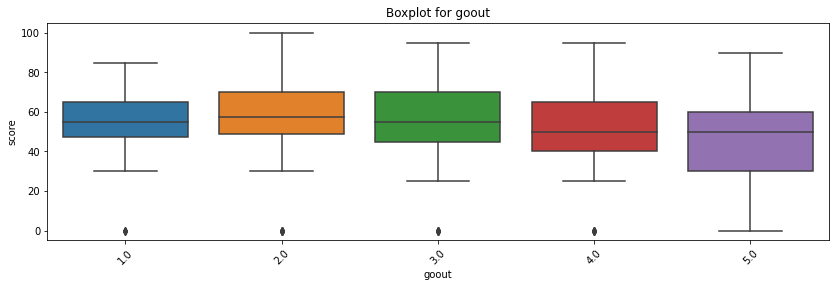

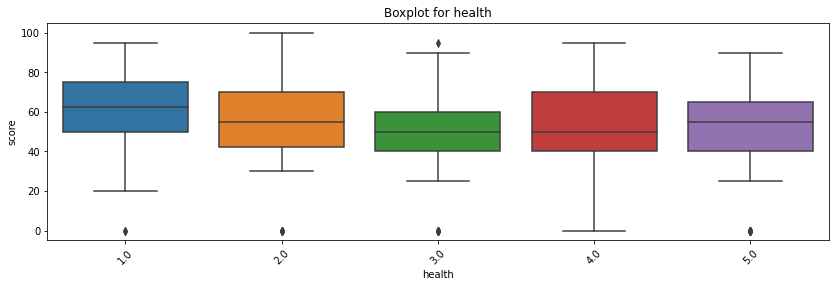

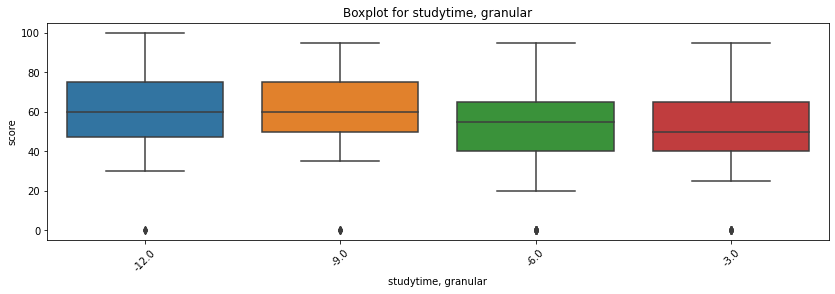

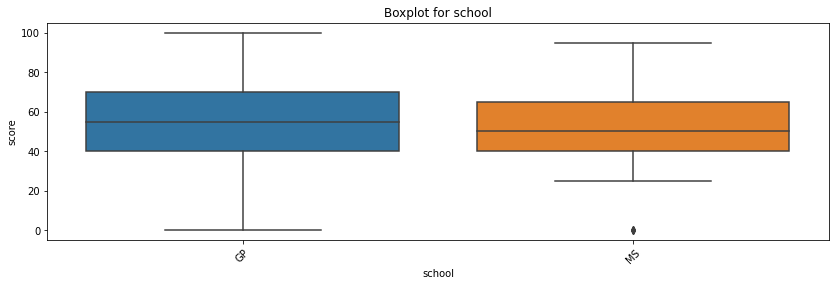

### Leave for further analisys:

**['address', 'Medu', 'Mjob', 'failures', 'higher', 'romantic']**

### Drop:

**['sex', 'famsize', 'Pstatus', 'Fedu', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'internet', 'famrel', 'freetime', 'goout', 'health', 'studytime, granular', 'school']**

In [1467]:
#Use t-test to check if expected value of distribution "score" by nominal parameter is statistically different
#Function is shamelessly borrowed from the showcase project

def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        a = ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'], 
                     students.loc[students.loc[:, column] == comb[1], 'score']).pvalue
        if a <= 0.05/len(combinations_all): #Bonferroni Correction
            printmd(f'**Statistically significant differences of expected values discovered for column: {column}**')
            return True
    return False

def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=students,
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    return get_stat_dif(column) 


relevant_col = []
nonrelevant_col = []
for col in list(nom_categories) + ['studytime, granular', 'school']:
    if get_boxplot(col):
        relevant_col.append(col)
    else:
        nonrelevant_col.append(col)
        
printmd(f'### Leave for further analisys:')
printmd(f'**{relevant_col}**')
printmd(f'### Drop:')
printmd(f'**{nonrelevant_col}**')


In [1468]:
#Drop non-relevant columns:

#students.to_csv(path_or_buf="./processed_data", sep='\t')

students.drop(nonrelevant_col, axis=1, inplace=True)

## Final proprocessed data for ML model:

In [1469]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       389 non-null    int64  
 1   address   389 non-null    object 
 2   Medu      389 non-null    float64
 3   Mjob      389 non-null    object 
 4   failures  389 non-null    float64
 5   higher    389 non-null    object 
 6   romantic  389 non-null    object 
 7   absences  389 non-null    float64
 8   score     389 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 40.4+ KB


In [1470]:
students.sample(50)

,age,address,Medu,Mjob,failures,higher,romantic,absences,score
136,17,R,3.0,at_home,0.0,yes,no,0.0,0.0
255,17,U,1.0,health,1.0,yes,no,2.0,40.0
52,15,U,4.0,health,1.0,yes,no,6.0,50.0
30,15,U,4.0,health,0.0,yes,no,0.0,60.0
1,17,U,1.0,at_home,0.0,yes,no,4.0,30.0
20,15,U,4.0,teacher,0.0,yes,no,0.0,75.0
257,19,U,4.0,services,0.0,yes,no,12.0,55.0
228,18,U,2.0,at_home,0.0,yes,yes,14.0,45.0
248,18,R,3.0,other,1.0,yes,yes,8.0,25.0
130,15,R,3.0,services,2.0,yes,yes,0.0,0.0
